Now that all of the data is processed, next step is to feed it to Presto and use the embeddings for classification.

In [1]:
import geopandas as gpd
import os
from pathlib import Path
import torch
from tqdm import tqdm
from itertools import product
from fastcore.basics import ifnone
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

import sys
sys.path.append('..')
from presto import Presto, construct_single_presto_input

device = 'cuda' if torch.cuda.is_available() else 'cpu'

First read the data and convert it to `epsg:4326`, as one of the inputs to Presto is `latlon`.

In [2]:
gdf = gpd.read_file('../data/sampled_data.gpkg').to_crs('epsg:4326')
gdf.head()

,label,InvLK,elevation,slope,precipitation_2020_1,precipitation_2020_2,precipitation_2020_3,precipitation_2020_4,precipitation_2020_5,precipitation_2020_6,...,B8A_2022_4,B8A_2022_5,B8A_2022_6,B8A_2022_7,B8A_2022_8,B8A_2022_9,B8A_2022_10,B8A_2022_11,B8A_2022_12,geometry
0,Sammal-varpu-ruoho (lehtomainen),251,275.101013,9.585938,56.578560,49.518848,42.750782,25.724018,40.207382,48.631065,...,6520.0,2730.0,3558.0,4075.0,3867.0,1868.0,NaN,NaN,NaN,POINT (27.33389 69.95989)
1,Sammal-varpu (tuore),242,258.298004,11.140625,56.578560,49.518848,42.750782,25.724018,40.207382,48.631065,...,7808.0,3302.0,3610.5,4269.0,4022.0,2398.5,NaN,NaN,NaN,POINT (27.34913 69.95722)
2,Sammal-varpu-ruoho (lehtomainen),251,253.636993,12.406250,56.578560,49.518848,42.750782,25.724018,40.207382,48.631065,...,6526.0,3434.0,4079.5,5098.0,3191.0,2553.0,NaN,NaN,NaN,POINT (27.35595 69.95753)
3,Sammal-varpu (tuore),242,254.406998,8.546875,56.578560,49.518848,42.750782,25.724018,40.207382,48.631065,...,7326.0,3515.0,3626.0,4235.0,4046.0,2737.5,NaN,NaN,NaN,POINT (27.35055 69.9519)
4,Sammal-varpu (tuore),242,274.809998,10.632812,58.559845,53.056049,43.816322,26.595482,42.261738,50.804619,...,9489.0,3514.0,3420.5,3384.0,3110.0,3433.0,4417.0,NaN,NaN,POINT (27.36722 69.9478)


Check the dimensions of the dataframe.

In [3]:
gdf.shape

(1397, 509)

Next, specify 

* `years_to_use`. The maximum lenght is 24 months
* Band names for Presto, and extracting the data from dataframes

In [4]:
years_to_use = [2020,2021]

s2_bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']
s2_bands_for_presto = ['B1','B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']

era5_bands = ['temperature_2m', 'total_precipitation']
srtm_bands = ['elevation', 'slope']

s2_datacols = [f'{b}_{y}_{m}' for b,y,m in product(s2_bands,years_to_use,range(1,13))]
era5_datacols = [f'{b}_{y}_{m}' for b, y, m in product(['temperature', 'precipitation'], years_to_use, range(1,13))]

`construct_single_presto_input` handles converting the data to presto suitable format. Here we do some reshaping and conversion:

* For S2 (and S1 provided it's available) data, the data is reshaped into a `[11, 12*n_years]` matrix, so that each band has full time series
* Data corresponding to ERA5 bands has to be converted so that
    * Temperature is in Kelvin (so add 273.15 to it) and temperature is in meters (so multiply it with 0.001).
* Elevation data is constant for each timestep

Finally all locations with nan are masked.

In [5]:
def construct_single_presto_input_batched(gdf, s2_datacols, era5_datacols, n_years=1):
    inp_len = len(gdf)
    arrays, masks, dws = [], [], []
    for i in tqdm(range(inp_len)):
        x, mask, dw = construct_single_presto_input(
                        s1=None,
                        s1_bands=None,
                        s2=torch.from_numpy(gdf[s2_datacols].iloc[i].values.reshape((11,12*n_years))).to(torch.float32).T,
                        s2_bands=s2_bands_for_presto,
                        era5=torch.from_numpy((gdf[era5_datacols].iloc[i].values.reshape(2,12*n_years).T + [273.15, 0]) * [1, 0.001]).to(torch.float32),
                        era5_bands=era5_bands,
                        srtm=torch.from_numpy(np.array([(gdf['elevation'].iloc[i], gdf['slope'].iloc[i]) for _ in range(12*n_years)])).to(torch.float32),
                        srtm_bands=srtm_bands,
                        normalize=True
                    )

        # Detect nan locations and mask them
        x_nans = torch.isnan(x)
        mask[x_nans] = 1
        x = torch.nan_to_num(x)
        arrays.append(x); masks.append(mask); dws.append(dw)
    return (torch.stack(arrays), torch.stack(masks), torch.stack(dws))

As mentioned before, one of the inputs are latlons, so get them into a tensor as well.

In [6]:
latlons = torch.tensor(np.stack([gdf.geometry.y.values, gdf.geometry.x.values], axis=1))

Create the tensors

In [7]:
x, mask, dw = construct_single_presto_input_batched(gdf, s2_datacols, era5_datacols, n_years=len(years_to_use))

100%|██████████████████████████████████████████████████████████████| 1397/1397 [00:02<00:00, 563.19it/s]


Put them into a tuple

In [8]:
ds = (
    x.to(device), 
    mask.to(device), 
    dw.to(device), 
    latlons.to(device)
)

Specify start month for the data. 0 is January.

In [9]:
month = torch.tensor([0] * ds[0].shape[0]).long().to(device)


And create the dataloader

In [10]:
dl = DataLoader(
    TensorDataset(
        ds[0].float(),  # x
        ds[1].bool(),  # mask
        ds[2].long(),  # dynamic world
        ds[3].float(),  # latlons
        month, 
    ),
    batch_size=64,
    shuffle=False,
)

Next, Construct the model, load state dict and put it into same device than all the other data.

In [11]:
model = Presto.construct()
model.load_state_dict(torch.load('../models/default_model.pt', map_location=device))
model.to(device)


Presto(
  (encoder): Encoder(
    (eo_patch_embed): ModuleDict(
      (S1): Linear(in_features=2, out_features=128, bias=True)
      (S2_RGB): Linear(in_features=3, out_features=128, bias=True)
      (S2_Red_Edge): Linear(in_features=3, out_features=128, bias=True)
      (S2_NIR_10m): Linear(in_features=1, out_features=128, bias=True)
      (S2_NIR_20m): Linear(in_features=1, out_features=128, bias=True)
      (S2_SWIR): Linear(in_features=2, out_features=128, bias=True)
      (ERA5): Linear(in_features=2, out_features=128, bias=True)
      (SRTM): Linear(in_features=2, out_features=128, bias=True)
      (NDVI): Linear(in_features=1, out_features=128, bias=True)
    )
    (dw_embed): Embedding(10, 128)
    (latlon_embed): Linear(in_features=3, out_features=128, bias=True)
    (blocks): ModuleList(
      (0-1): 2 x Block(
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=128, out_features=384, bias=True)

Now Presto can be used to generate embeddings for the data.

In [12]:
embeddings = []
for (x, mask, dw, latlons, month) in tqdm(dl):
    with torch.no_grad():
        model.eval()
        embeddings.append(model.encoder(x=x, mask=mask, dynamic_world=dw, latlons=latlons, month=month).cpu())

100%|███████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 12.80it/s]


These embeddings can then be used with e.g. `RandomForestClassifier`. 

First, encode the habitat type labels into integers.

In [13]:
le = LabelEncoder()
le.fit(gdf.label.unique())
gdf['enc_label'] = le.transform(gdf.label)

Initialize classifier

In [14]:
clf_all = RandomForestClassifier(n_estimators=500, oob_score=True)
#clf_all = GradientBoostingClassifier(subsample=0.7, max_depth=5)
#clf_all = HistGradientBoostingClassifier()

Move the embeddings to cpu, split into train and test sets and fit the classifier

In [15]:
lin_embeddings = torch.concat(embeddings).cpu().numpy()

x_train, x_test, y_train, y_test = train_test_split(lin_embeddings, gdf.enc_label, random_state=55)

clf_all.fit(x_train, y_train)

,n_estimators,500
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


Next get the predictions and see the performance.

In [16]:
y_pred = clf_all.predict(x_test)

In [17]:
print(classification_report(y_test, y_pred, labels=gdf.enc_label.unique(), target_names=gdf.label.unique(), zero_division=np.nan))

                                   precision    recall  f1-score   support

 Sammal-varpu-ruoho (lehtomainen)       0.43      0.56      0.49        32
             Sammal-varpu (tuore)       0.51      0.68      0.58        84
   Jäkälä-sammal-varpu (kuivahko)       0.54      0.71      0.61        68
              Räme-rimpipintasuot       0.29      0.33      0.31         6
             Ruohoinen heinä-sara       0.20      0.08      0.11        25
             Korpi-rimpipintasuot        nan      0.00      0.00         2
           Sammaleinen heinä-sara       0.36      0.31      0.33        13
             Varsinaiset rämesuot       0.40      0.31      0.35        13
              Korpi-välipintasuot        nan      0.00      0.00         3
                    Välipintasuot        nan      0.00      0.00         4
                   Rimpipintasuot       0.50      0.33      0.40         6
             Jäkälä-varpu (kuiva)       0.62      0.33      0.43        15
                  Järvi 

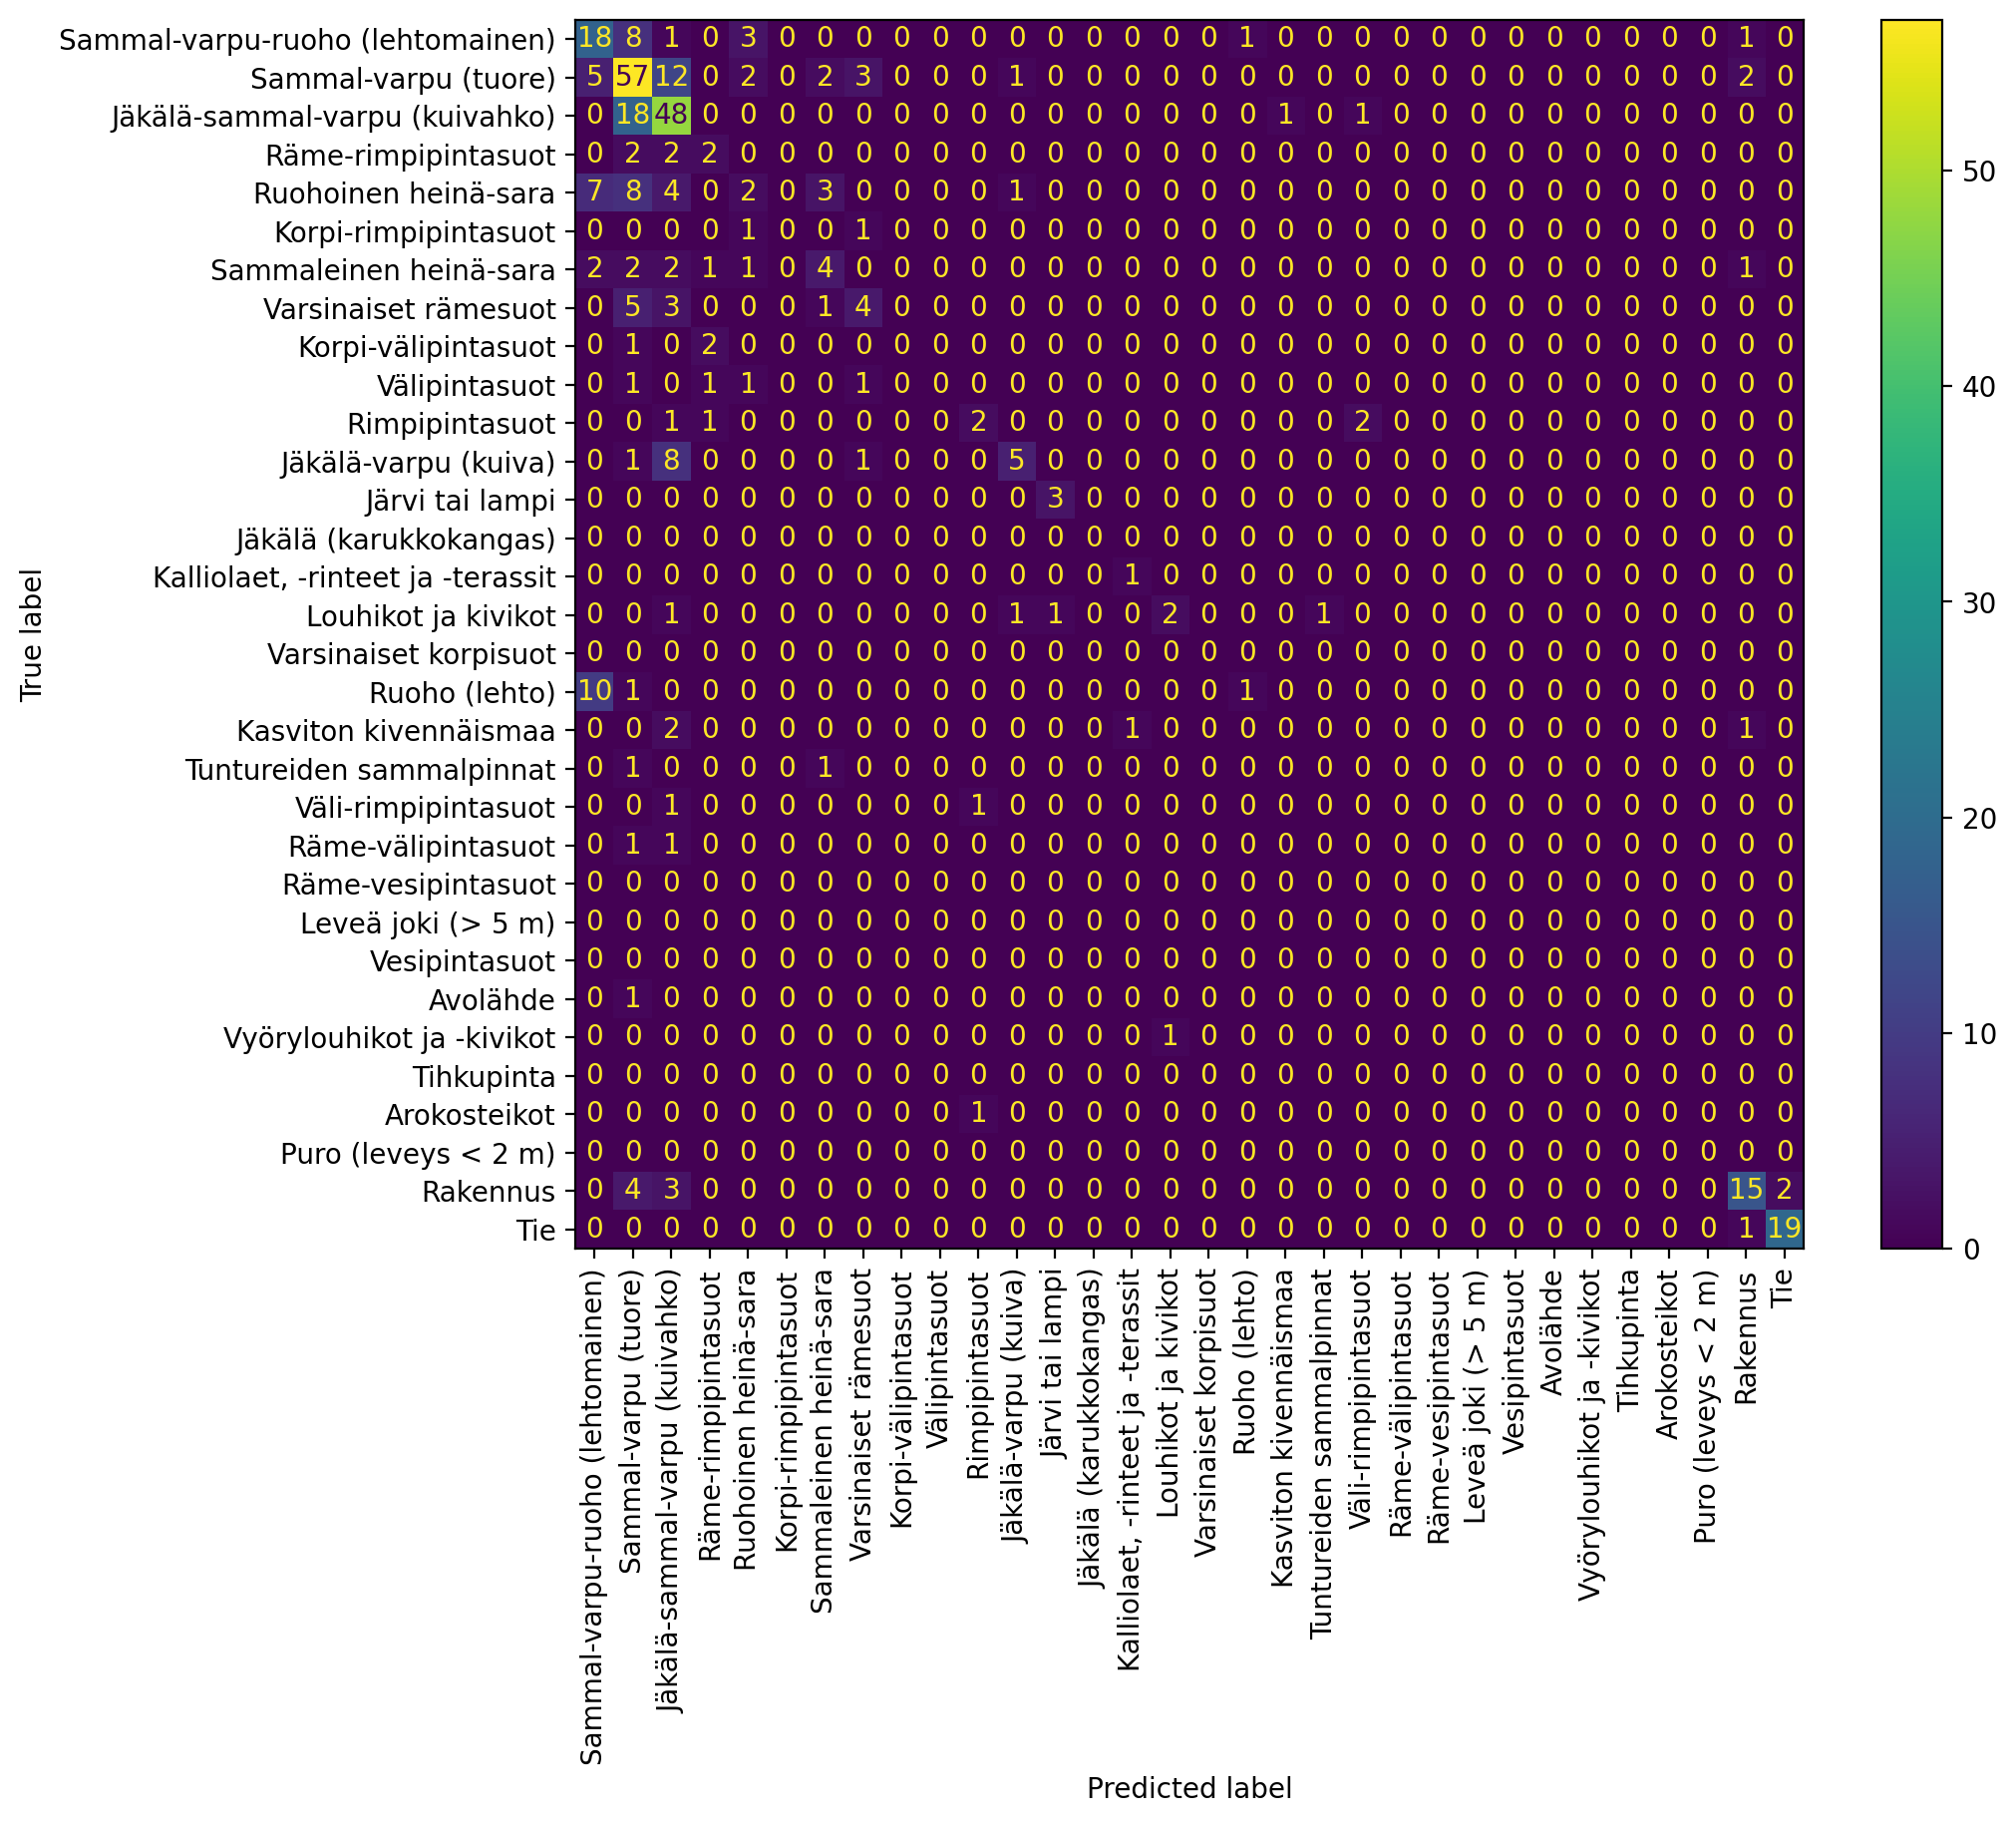

In [21]:
fig, ax = plt.subplots(1,1,dpi=200, figsize=(10,8))

disp = ConfusionMatrixDisplay.from_estimator(clf_all, x_test, y_test, labels=gdf.enc_label.unique(), normalize=None,
                                             display_labels=gdf.label.unique(), ax=ax, xticks_rotation='vertical')